## Introduction to Time Series Analysis

### What is a Time Series?

A Time Series is a **time-indexed** series of data. In Finance, a time series tracks the movement of the chosen data points, such as a *security’s price*, over a specified period of time with data points recorded at **regular intervals**.

## Why is it used for?

Time series analysis can be useful to see how a given asset, security, or economic variable changes over time. It can also be used to examine how the changes associated with the chosen data point compare to shifts in other variables over the same time period.

For example, suppose you wanted to analyze a time series of daily closing stock prices for a given stock over a period of one year. You would obtain a list of all the closing prices for the stock from each day for the past year and list them in chronological order. 

## <div id="summary">Summary</div>

**<font size="2"><a href="#chap1">Import data</a></font>**
**<br><font size="2"><a href="#chap2">Representation</a></font>**
**<br><font size="2"><a href="#chap3">Missing data</a></font>**
**<br><font size="2"><a href="#chap4">Seasonality</a></font>**
**<br><font size="2"><a href="#chap5">Time series components</a></font>**
**<br><font size="2"><a href="#chap6">Stationarity</a></font>**
**<br><font size="2"><a href="#chap7">Autocorrelation</a></font>**
**<br><font size="2"><a href="#chap8">Lag Scatter Plot</a></font>**
**<br><font size="2"><a href="#chap9">Moving Average</a></font>**
**<br><font size="2"><a href="#chap10">Exponential Smoothing</a></font>**
**<br><font size="2"><a href="#chap11">Forecasting with Auto ARIMA</a></font>**

## Import libraries

In [1]:
# Regular libraries for data manipulation
import pprint
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer

# Visualization
from pandas.plotting import lag_plot
import matplotlib.pyplot as plt
import seaborn as sns

# Statistical tools for time series analysis
from scipy import signal
import statsmodels.api as sm
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.tools import diff
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller, kpss, acf, grangercausalitytests
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf,month_plot,quarter_plot
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

sns.set_style("whitegrid")
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15)

from pylab import rcParams

## Import data

In [2]:
path_daily_data = "../../Data/df_ohlcv_daily.h5"
df_tics_daily = pd.read_hdf(path_daily_data, "df",mode = 'r')

In [3]:
df_tics_daily.tail(2)

,date,tic,open,high,low,close,adj_close,volume
3291,2024-02-01,NVDA,621.00000,631.909973,616.500000,630.270020,630.270020,36914600
3292,2024-02-02,NVDA,639.73999,666.000000,636.900024,661.599976,661.599976,47578000


In [4]:
# Filtering the dataframe to focus on NVDA stocks
df_tic = df_tics_daily[df_tics_daily['tic'] == 'NVDA'].copy()

# Converting the 'Date' column to a datetime object
df_tic['date'] = pd.to_datetime(df_tic['date'])

In [5]:
# Extracting year and month from the 'Date' column and adding them as separate columns
df_tic['Year'] = df_tic['date'].dt.year
df_tic['Month'] = df_tic['date'].dt.month

# Printing the shape of the 'air_liquide' dataframe
print(f'df_tic shape: {df_tic.shape[0]} rows, {df_tic.shape[1]} columns')

df_tic shape: 3293 rows, 10 columns


In [6]:
df_tic.head()

,date,tic,open,high,low,close,adj_close,volume,Year,Month
0,2011-01-03,NVDA,3.8800,3.9925,3.8750,3.9550,3.628100,81744800,2011,1
1,2011-01-04,NVDA,3.9625,3.9800,3.8550,3.9425,3.616633,65138400,2011,1
2,2011-01-05,NVDA,4.0150,4.2500,3.9750,4.2450,3.894129,142821600,2011,1
3,2011-01-06,NVDA,4.3550,4.8350,4.3425,4.8325,4.433071,349331200,2011,1
4,2011-01-07,NVDA,4.7775,4.9825,4.6700,4.9675,4.556913,257998400,2011,1


## Representation

A **line plot** represents a graphical method that showcases data as individual points or check marks positioned along a numerical axis, illustrating the frequency of each value. This type of visualization assists in identifying:

* **Outliers** or extreme values
* **Missing observations** (typically accompanied by error messages)
* **Data variability**
* **Seasonal patterns and trends** within the data

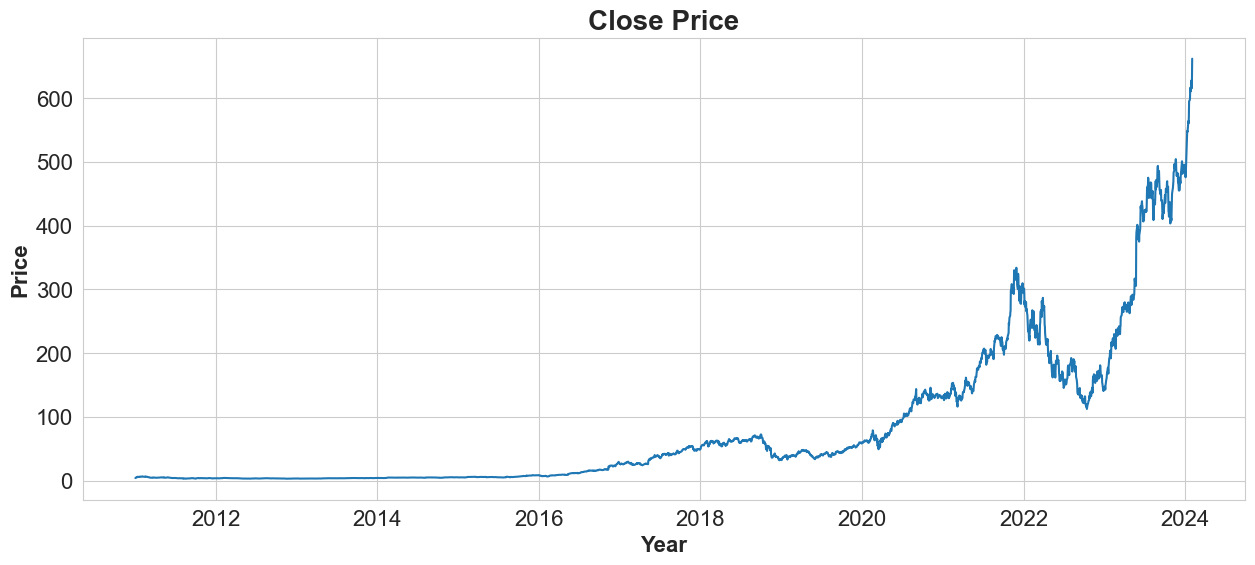

In [7]:
# Line plot
fig, ax = plt.subplots(figsize=(15, 6))
sns.lineplot(data=df_tic, x='date', y='close')

# Formatting
ax.set_title('Close Price', fontsize=20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Year', fontsize=16, fontdict=dict(weight='bold'))
ax.set_ylabel('Price', fontsize=16, fontdict=dict(weight='bold'))

# Adjusting tick label sizes for better readability
plt.tick_params(axis='y', which='major', labelsize=16)
plt.tick_params(axis='x', which='major', labelsize=16)

The data does not appear to exhibit any discernible seasonality within each year. Instead, it demonstrates a trend as opposed to cyclical behavior. A notable decrease in price can be observed in early 2020, attributable to the COVID-19 pandemic.

## Missing data

In most instances, addressing missing data requires a case-by-case approach. Several methods can be employed to impute missing values:

* **Forward Fill and Backward Fill**: Forward filling entails replacing missing values with the preceding data point, while backward filling involves filling in missing values with the subsequent data point.
* **Linear Interpolation**: This technique involves using linear polynomials to estimate new data points within the scope of a discrete set of existing data points.
* **Quadratic Interpolation**: This method utilizes non-linear polynomials to estimate new data points within the range of a discrete set of known data points.
* **Mean of Nearest Neighbors**
* **Mean of Seasonal**

In [8]:
# Check the number of NaN values in each column of the dataframe
df_tic.isna().sum()

date         0
tic          0
open         0
high         0
low          0
close        0
adj_close    0
volume       0
Year         0
Month        0
dtype: int64

In [9]:
# Retrieve the index of the missing value in the 'Open' column
index_open_missing = df_tic[pd.isnull(df_tic['close'])].index
print("index of the missing value in the close column:", list(index_open_missing))

index of the missing value in the close column: []


In [10]:
# Replace the missing value in the 'close' column with the value from the previous day (backward fill)
df_tic['close'] = df_tic['close'].fillna(method='bfill')

# Calculate and print the percentage of missing values in the 'Volume' column
print(f"Percentage of missing values in Volume: {round(sum(pd.isnull(df_tic['volume']))/df_tic.shape[0],2)}\n")
print(df_tic[df_tic['volume']==0])

Percentage of missing values in Volume: 0.0

Empty DataFrame
Columns: [date, tic, open, high, low, close, adj_close, volume, Year, Month]
Index: []


Missing values in the 'volume' column account for x% of the observations. Additionally, no instances of a zero value are present. It is reasonable to assume that a missing value signifies a trading volume of zero stocks for that particular observation.

In [11]:
# Missing values in the 'volume' column are replaced by 0
imputer = SimpleImputer(strategy='constant', fill_value=0)
imputed_df_tic = imputer.fit_transform(df_tic)

# Imputation removed column names; put them back
imputed_df_tic = pd.DataFrame(imputed_df_tic)

# Create a new dataframe with imputed values
imputed_df_tic.columns = df_tic.columns

In [12]:
# Replace comma by period so volume can be converted to float
imputed_df_tic['volume'] = imputed_df_tic['volume'].apply(lambda x : str(x))
imputed_df_tic['volume'] = pd.to_numeric(imputed_df_tic['volume'].apply(lambda x : x.replace(',','',1)))

# Convert object type columns to numeric 
imputed_df_tic['open'] = pd.to_numeric(imputed_df_tic['open'])
imputed_df_tic['close'] = pd.to_numeric(imputed_df_tic['close'])
imputed_df_tic['high'] = pd.to_numeric(imputed_df_tic['high'])
imputed_df_tic['low'] = pd.to_numeric(imputed_df_tic['low'])

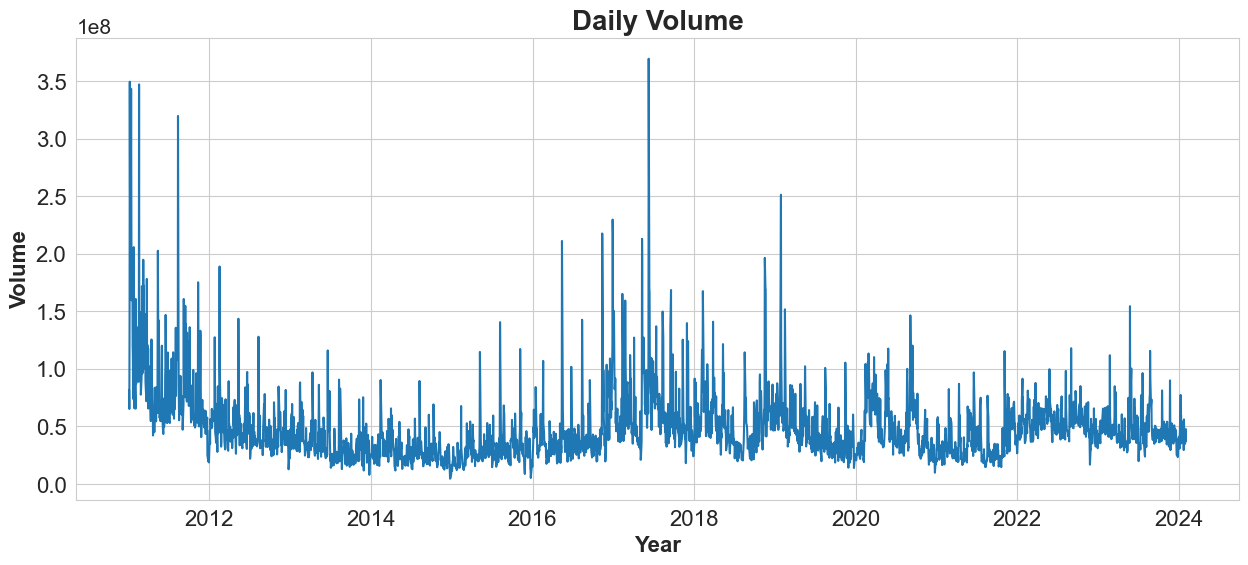

In [13]:
# Plot Daily Volume Lineplot
fig, ax = plt.subplots(figsize=(15, 6))
sns.lineplot(imputed_df_tic, x = 'date', y = 'volume')

# Formatting
ax.set_title('Daily Volume', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Year', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('Volume', fontsize = 16, fontdict=dict(weight='bold'))
plt.tick_params(axis='y', which='major', labelsize=16)
plt.tick_params(axis='x', which='major', labelsize=16)

The graph exhibits significant noise due to the use of a daily scale. By opting for the mean trading volume per month, rather than the daily trading volume, the resulting visualization is expected to be more comprehensible and visually appealing.

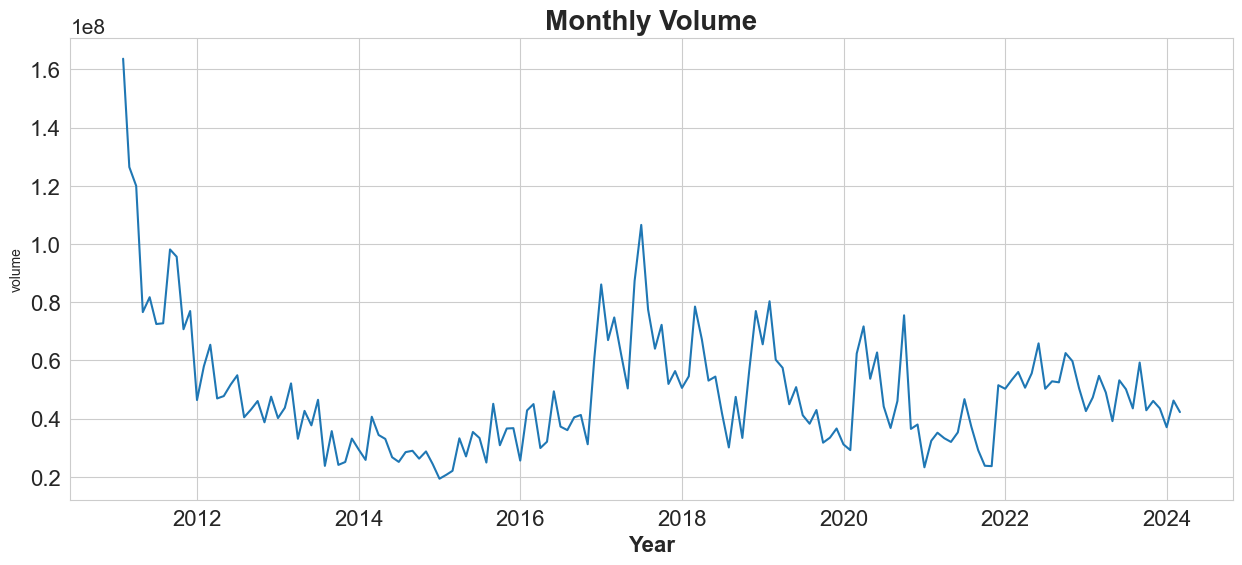

In [14]:
# Create a copy of the 'Date' and 'Volume' columns
y = imputed_df_tic[['date','volume']].copy()

# Set the index to 'Date' and convert it to datetime format
y.set_index('date', inplace=True)
y.index = pd.to_datetime(y.index)

# Resample the time series to monthly and compute the mean of each month
y = y.resample('1M').mean()

# Add the 'Date' column back to the DataFrame
y['date'] = y.index

# Plot the monthly volume time series
fig, ax = plt.subplots(figsize=(15, 6))
sns.lineplot(y , x = 'date', y = 'volume')

# Set the title and axes labels
ax.set_title('Monthly Volume', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Year', fontsize = 16, fontdict=dict(weight='bold'))
plt.tick_params(axis='y', which='major', labelsize=16)
plt.tick_params(axis='x', which='major', labelsize=16)

Although the graph remains somewhat noisy, it is now more interpretable. The optimal period interval must be chosen to strike a balance between readability and the preservation of information.

* **Short period interval**: <font color='red'>Noisy signal</font>, <font color='green'>richer information</font>
* **Long period interval**: <font color='green'>Easily understandable signal</font>, <font color='red'>reduced information</font>

## Seasonality

### What is seasonality

In Time Series data, seasonality is the presence of variations that **occur** at **specific regular intervals less than a year**, such as **weekly**, **monthly**, or **quarterly**.

In [15]:
imputed_df_tic['Year'] = imputed_df_tic['date'].dt.year
imputed_df_tic['Month'] = imputed_df_tic['date'].dt.month

In [16]:
print(imputed_df_tic['Year'].unique())

[2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 2023 2024]


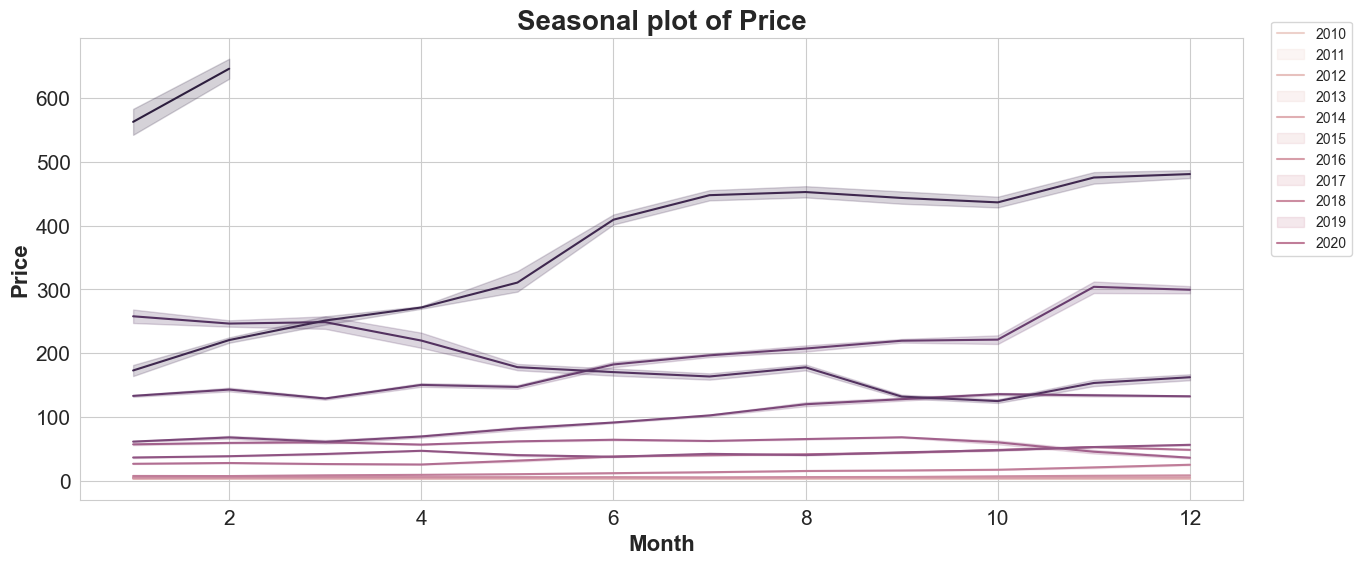

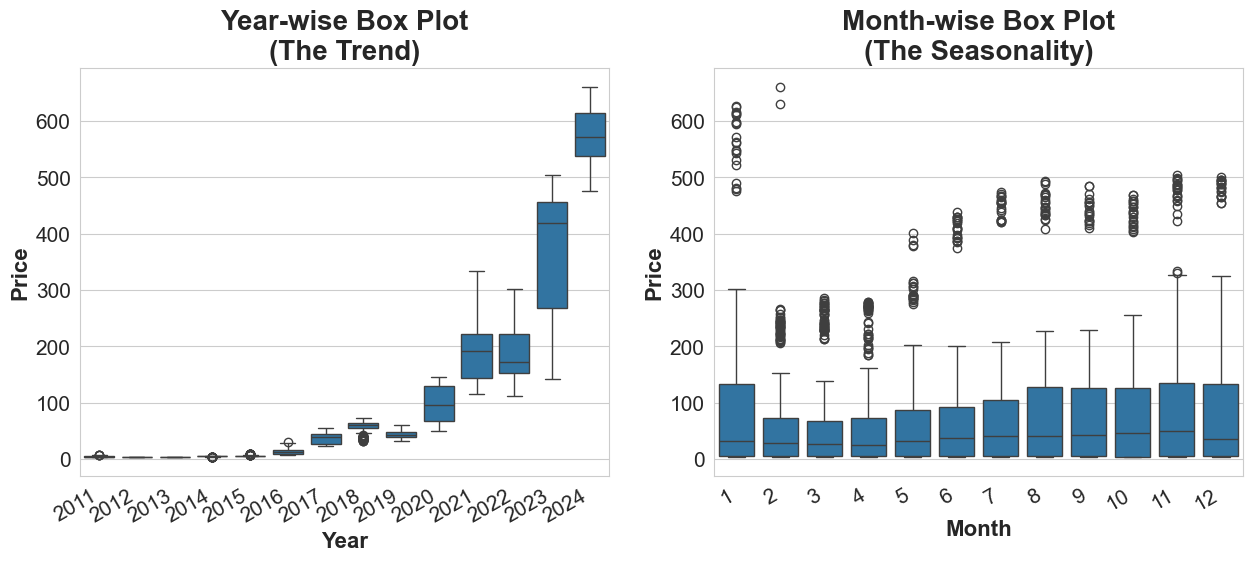

In [17]:
# Set the variable to plot
variable = 'close'

# Create a figure with one plot
fig, ax = plt.subplots(figsize=(15, 6))

# Plot the seasonal line plot
sns.lineplot(imputed_df_tic, x = 'Month', y = variable, hue = imputed_df_tic['Year'])

# Format the plot
ax.set_title('Seasonal plot of Price', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Month', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('Price', fontsize = 16, fontdict=dict(weight='bold'))
ax.legend(labels = [str(2010+i) for i in range(11)], bbox_to_anchor=(1.1, 1.05))

# Create a figure with two plots
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# Plot the year-wise box plot
sns.boxplot(imputed_df_tic, x = 'Year', y = variable, ax=ax[0])

# Format the year-wise box plot
ax[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax[0].set_xlabel('Year', fontsize = 16, fontdict=dict(weight='bold'))
ax[0].set_ylabel('Price', fontsize = 16, fontdict=dict(weight='bold'))

# Plot the month-wise box plot
sns.boxplot(imputed_df_tic, x = 'Month', y = variable, ax=ax[1])

# Format the month-wise box plot
ax[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax[1].set_xlabel('Month', fontsize = 16, fontdict=dict(weight='bold'))
ax[1].set_ylabel('Price', fontsize = 16, fontdict=dict(weight='bold'))

# Rotate the x-axis labels for better readability
fig.autofmt_xdate()

## An Effective Visualization

Overall, these plots enable you to:

* Assess the presence of seasonal patterns, if any
* Determine the years during which the pattern shifts
* Identify significant increases or decreases

In the trend and seasonality boxplot:

* Instantly examine trends and seasonality
* Identify outliers

Text(0, 0.5, 'close')

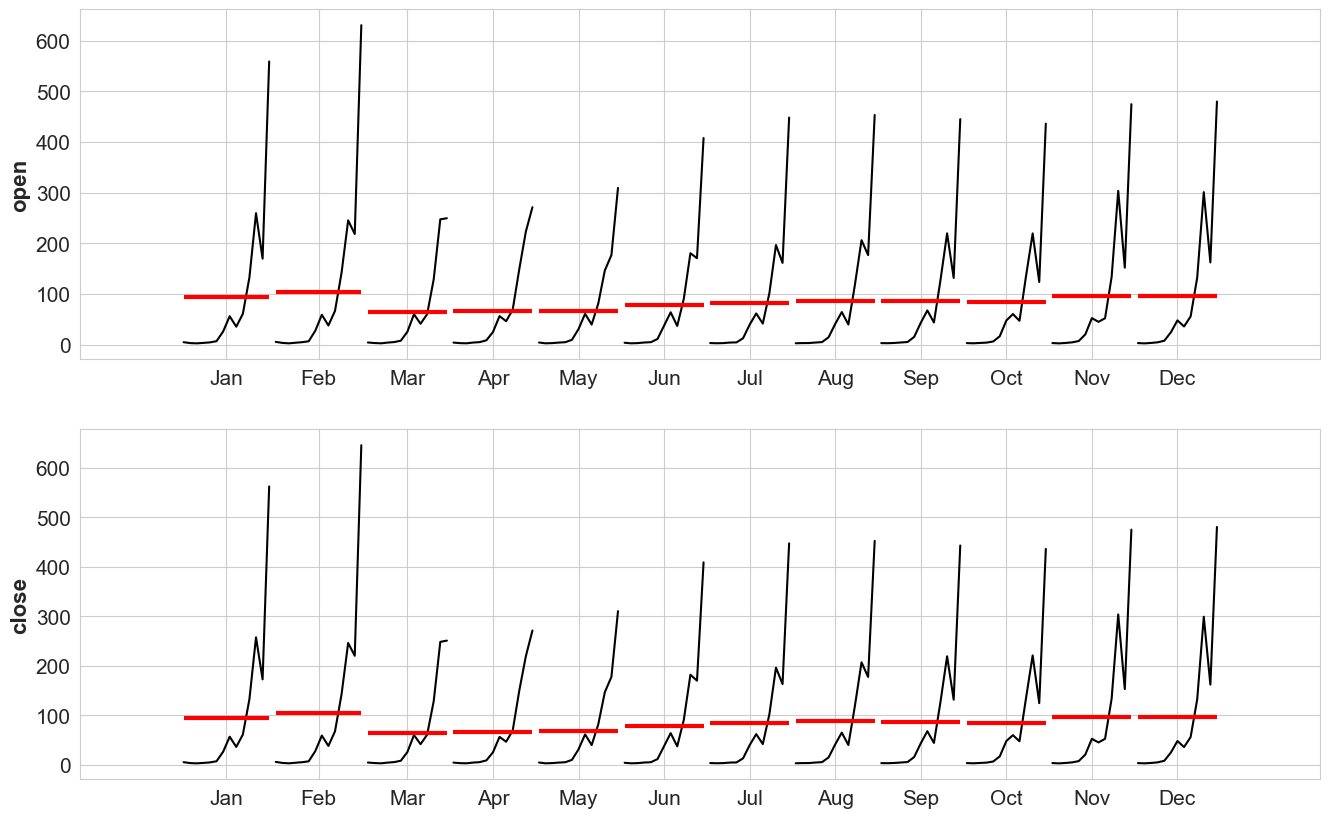

In [19]:
# Aggregating the Time Series to a monthly scaled index
y = imputed_df_tic[['date','open','close']].copy()
y.set_index('date', inplace=True)
y.index = pd.to_datetime(y.index)
y = y.resample('1M').mean()

# Create the seasonal subseries plots
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 10))

month_plot(y['open'], ax=ax[0]);
ax[0].set_ylabel('open', fontsize = 16, fontdict=dict(weight='bold'))

month_plot(y['close'], ax=ax[1]);
ax[1].set_ylabel('close', fontsize = 16, fontdict=dict(weight='bold'))

This graph employs a groupby function to provide a clearer view of potential monthly seasonality.

## Time Series components

If we assume an additive decomposition, then we can write

$$y_t = S_t + T_t + R_t$$

where $y_t$ is the data, $S_t$ is the seasonal component, $T_t$ is the trend-cycle component and $R_t$ is the residual component, all at period $t$.
Also,for a multiplicative decomposition, we have

$$y_t = S_t * T_t * R_t$$

The additive decomposition is the most appropriate if the magnitude of the seasonal fluctuations, or the variation around the trend-cycle, does not vary with the level of the time series. When the variation in the seasonal pattern, or the variation around the trend-cycle, appears to be proportional to the level of the time series, then a multiplicative decomposition is more appropriate. Multiplicative decompositions are common with economic time series.


Text(0.5, 0.98, 'Close decomposition')

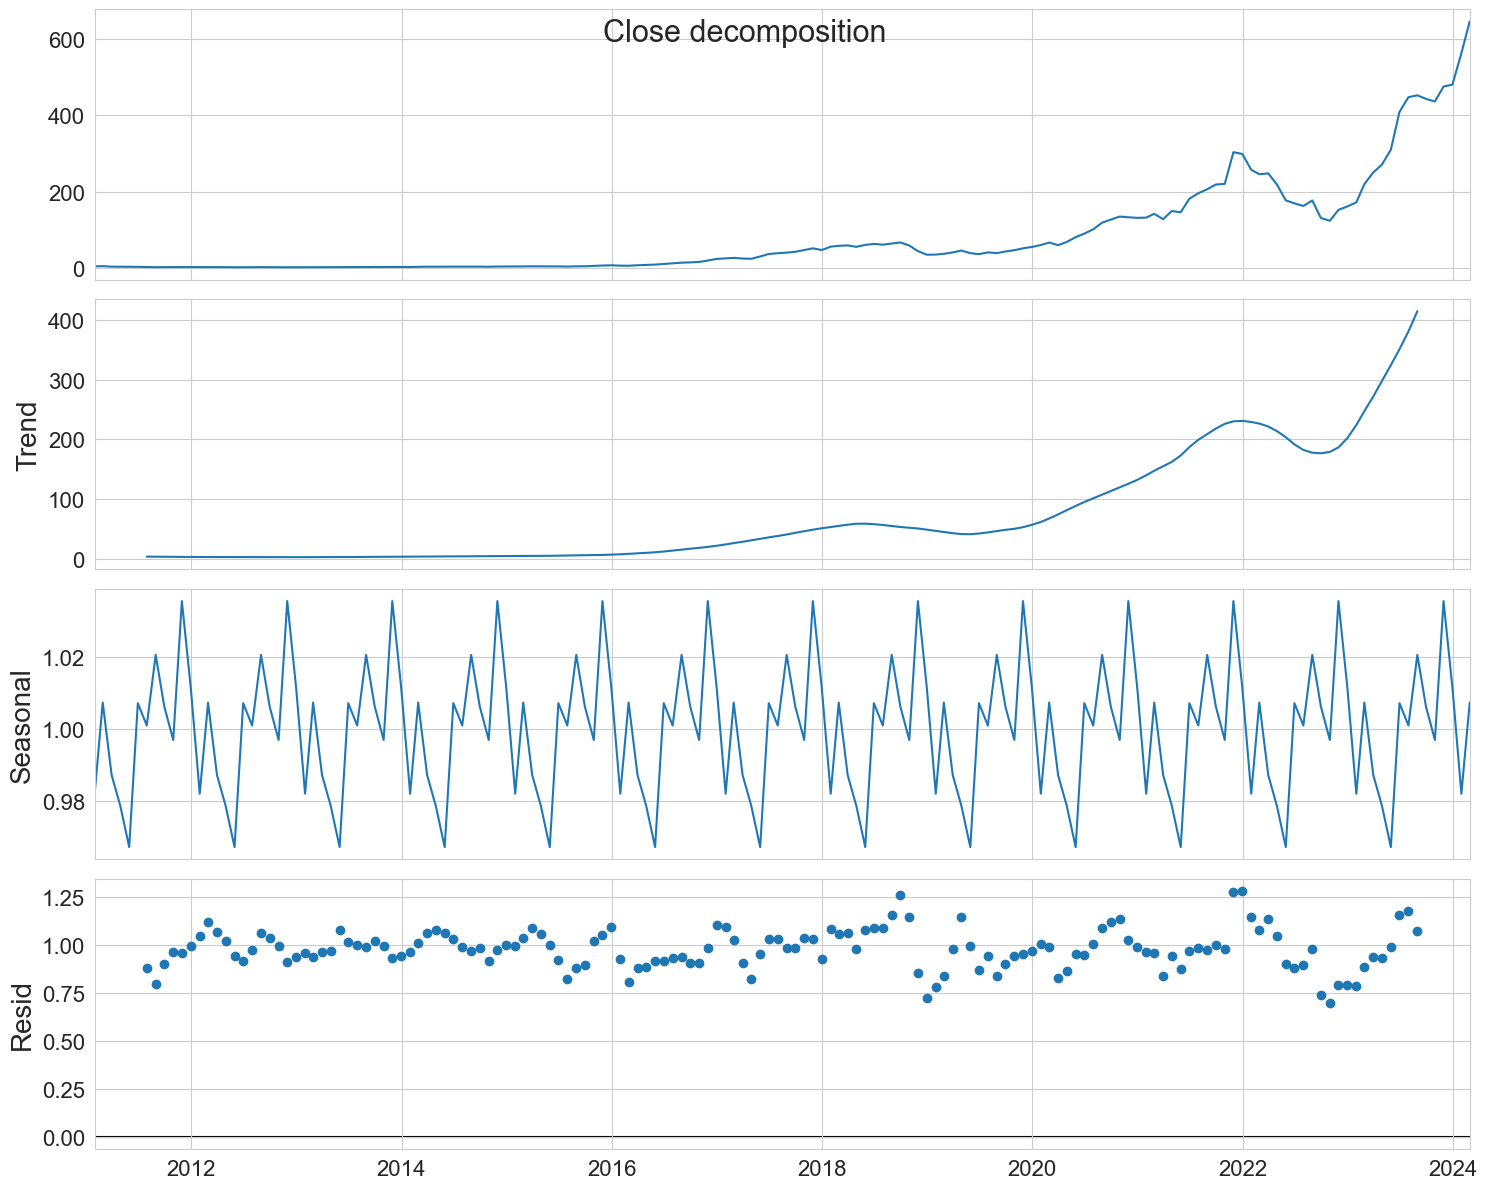

In [22]:
# Aggregating the Time Series to a monthly scaled index
y = imputed_df_tic[['date', 'close']].copy()
y.set_index('date', inplace=True)
y.index = pd.to_datetime(y.index)
y = y.resample('1M').mean()

# Setting rcparams for plot size and font size
rcParams['figure.figsize'] = 15, 12
rcParams['axes.labelsize'] = 20
rcParams['ytick.labelsize'] = 16
rcParams['xtick.labelsize'] = 16

# Using statistical tools of statsmodel library to perform seasonal decomposition
decomposition = sm.tsa.seasonal_decompose(y, model='multiplicative')

# Plotting the decomposition
decomp = decomposition.plot()
decomp.suptitle('Close decomposition', fontsize=22)


## Interpreting the Visualization

The three components are individually displayed in the bottom three panels. By multiplying these components together, the data presented in the >top panel can be reconstructed. It is evident that the seasonal component changes gradually over time. However, this does not imply that years >further apart will not exhibit distinct seasonal patterns.

The residual component depicted in the bottom panel represents the remaining values after subtracting the seasonal and trend-cycle components from >the data.

When the seasonal component is removed from the original data, the resulting values constitute the "seasonally adjusted" data. In the case of >additive decomposition, the seasonally adjusted data are obtained using $y_t - S_t$, while for multiplicative data, the seasonally adjusted values >are calculated using $y_t / S_t$.

**<font size="2"><a href="#summary">Back to summary</a></font>**

----

<div id="chap6"><h1 style="color:white;background:#5963ab;border-radius:5px;padding:30px;font-family:'Arial', cursive;font-size:50px;text-align:center">Stationarity</h1></div>

<font color='#5963ab' size='4'>Defining Stationarity</font>

<br>A stationary time series is one whose properties remain consistent regardless of the time at which the series is observed. Consequently, time series with trends or seasonality are not stationary. A time series exhibiting cyclical behavior (without trends or seasonality) is considered stationary.

<font color='#5963ab' size='4'>What is the purpose of stationarity?</font>

<br>Most statistical forecasting methods are tailored for stationary time series. The initial step in the forecasting process typically involves transforming a non-stationary series into a stationary one. Forecasting a stationary series is comparatively easier and yields more reliable results.

Linear regression performs optimally when predictors (X variables) are not correlated with one another. Stationarizing the series addresses this issue by eliminating persistent autocorrelation, rendering the predictors (lags of the series) in forecasting models nearly independent.

<font color='#5963ab' size='4'>How can a time series be made stationary?</font>

<br>There are several approaches:

* Differencing the series one or more times (subtracting the current value from the next value)
* Taking the logarithm of the series (helps stabilize the variance of a time series)
* Taking the $n_{th}$ root of the series
* Combining the methods above

To determine if a time series is stationary, one can:

* Examine the time plot
* Divide the series into two parts and compute descriptive statistics. If these differ, the series is non-stationary.
* Conduct statistical tests called Unit Root Tests, such as the Augmented Dickey Fuller test (ADF Test), Kwiatkowski-Phillips-Schmidt-Shin (KPSS test, trend stationary), and the Philips Perron test (PP Test).

The ADF test is the most commonly used, with the null hypothesis stating that the time series has a unit root (or random walk with drift) and is non-stationary. If the p-value in the ADF test is less than the significance level (0.05), the null hypothesis is rejected, and the series is deemed stationary.

In [18]:
def adf_test(series, title=''):
    """
    Perform the Augmented Dickey-Fuller test on a time series.

    Parameters:
        series (pd.Series): The time series to be tested.
        title (str): Optional title to be displayed in the results.

    Returns:
        None

    Prints an ADF report that includes the following statistics:
    - ADF test statistic
    - p-value
    - Number of lags used
    - Number of observations
    - Critical values at 1%, 5%, and 10% significance levels

    Also prints a conclusion about the stationarity of the series based on the p-value.

    Example:
        >>> adf_test(y['Open'], title='Open Prices')
    """
    
    print('Augmented Dickey-Fuller Test: {}'.format(title))
    
    # Perform Augmented Dickey-Fuller test
    result = adfuller(series.dropna(),autolag='AIC') 
    
    # Create a Series object with the test statistics and critical values
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)
    
    # Add the critical values to the Series object
    for key,val in result[4].items():
        out['critical value ({})'.format(key)]=val
        
    # Print the ADF report
    print(out.to_string())          
    
    # Check for stationarity based on the p-value
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [19]:
# Aggregating the Time Series to a monthly scaled index
y = imputed_air_liquide[['Date','Open']].copy()
y.set_index('Date', inplace=True)
y.index = pd.to_datetime(y.index)
y = y.resample('1M').mean()

# Perform the ADF test on the Open prices
adf_test(y['Open'],title='')

Augmented Dickey-Fuller Test: 
ADF test statistic       -0.196686
p-value                   0.938915
# lags used               2.000000
# observations          121.000000
critical value (1%)      -3.485585
critical value (5%)      -2.885739
critical value (10%)     -2.579676
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


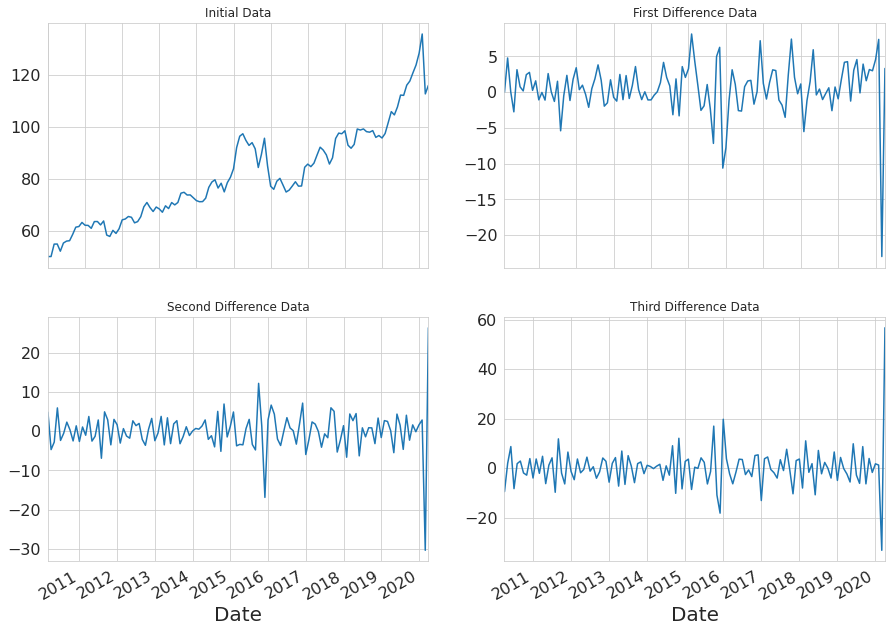

In [20]:
# Create a 2x2 grid of subplots
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 11))

# Apply differencing to the 'Open' column and add it to the dataframe
y['OpenDiff1'] = diff(y['Open'], k_diff=1)
y['OpenDiff2'] = diff(y['Open'], k_diff=2)
y['OpenDiff3'] = diff(y['Open'], k_diff=3)

# Plot the initial 'Open' data on the first subplot
y['Open'].plot(title="Initial Data", ax=ax[0][0]).autoscale(axis='x', tight=True);

# Plot the first difference data on the second subplot
y['OpenDiff1'].plot(title="First Difference Data", ax=ax[0][1]).autoscale(axis='x', tight=True);

# Plot the second difference data on the third subplot
y['OpenDiff2'].plot(title="Second Difference Data", ax=ax[1][0]).autoscale(axis='x', tight=True);

# Plot the third difference data on the fourth subplot
y['OpenDiff3'].plot(title="Third Difference Data", ax=ax[1][1]).autoscale(axis='x', tight=True);

# Rotate the x-axis labels to make them easier to read
fig.autofmt_xdate()

**<font size="2"><a href="#summary">Back to summary</a></font>**

----

<div id="chap7"><h1 style="color:white;background:#5963ab;border-radius:5px;padding:30px;font-family:'Arial', cursive;font-size:50px;text-align:center">Autocorrelation</h1></div>

<font color='#5963ab' size='4'>Differentiating Correlation, Autocorrelation, and Partial Autocorrelation</font>

<br>**Correlation** quantifies the degree of a linear relationship between two variables.

**Autocorrelation** evaluates the linear relationship between lagged values of a time series, such as between $y_t$ and $y_{t-1}$. A significant autocorrelation implies that previous values of the series (lags) could be useful in predicting the current value.

**Partial autocorrelations** assess the linear dependence of one variable after accounting for the influence of other variable(s) that impact both variables. In other words, the partial autocorrelation at lag k represents the autocorrelation between $y_t$ and $y_{t} + y_{t+k}$, excluding the effects of lags 1 through k−1.

Typically, we plot the relationship between the previous day's/month's residuals and the actual values of the current day. Generally, partial autocorrelation is expected to decline rapidly.

[1.         0.99669167 0.99397744 0.99114807 0.98842329 0.98574882
 0.98327505 0.98065432 0.97792933 0.97569862 0.97316217 0.97091567
 0.96872365 0.96677005 0.96448024 0.96224729 0.95968184 0.95699272
 0.95423987 0.95126885 0.94815404 0.94479836 0.94160485 0.93854499
 0.93560843 0.93284805 0.92976929 0.92688093 0.92378304 0.92046489
 0.91730545 0.91394706 0.91064856 0.90743726 0.90426107 0.90102265
 0.89772752 0.89464738 0.89163062 0.88862379 0.88584496 0.88294789
 0.88021878 0.87768629 0.87519469 0.87266679 0.87039248 0.86809038
 0.86572663 0.86328034 0.86084315 0.85844897 0.85612914 0.85390287
 0.85154451 0.84929882 0.84707093 0.84483261 0.84257198 0.84030894
 0.83812315]


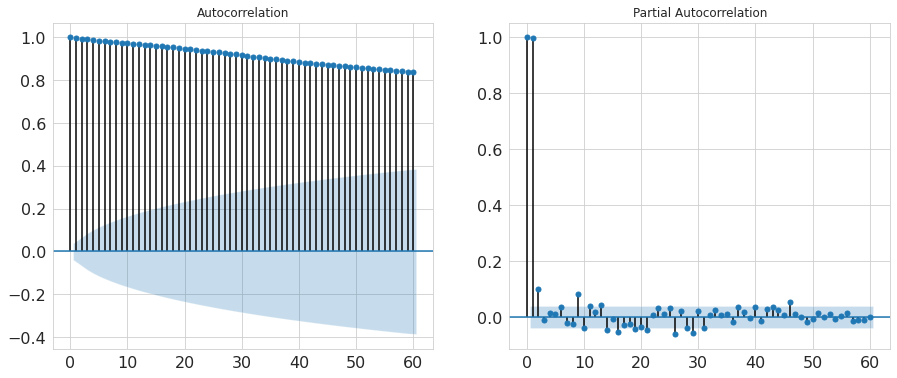

In [21]:
# Creating a figure with two subplots
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(15, 6))

# Calculating autocorrelation function (ACF) with 60 lags for Open prices
autocorr = acf(imputed_air_liquide['Open'], nlags=60, fft=False)
print(autocorr)

# Plotting the ACF with 60 lags on the first subplot
plot_acf(imputed_air_liquide['Open'].tolist(), lags=60, ax=ax[0], fft=False);

# Plotting the partial autocorrelation function (PACF) with 60 lags on the second subplot
plot_pacf(imputed_air_liquide['Open'].tolist(), lags=60, ax=ax[1]);

* For autocorrelation, the y-axis is the value for the correlation between a value and its lag. The lag is on the x-axis. The zero-lag has a correlation of 1 because it correlates with itself perfectly. 
* The autocorrelation plot shows that most of the spikes are not statistically significant. This indicates that the returns are not highly correlated, as shown here.

**<font size="2"><a href="#summary">Back to summary</a></font>**

-----

<div id="chap8"><h1 style="color:white;background:#5963ab;border-radius:5px;padding:30px;font-family:'Arial', cursive;font-size:50px;text-align:center">Lag Scatter Plot</h1></div>

<font color='#5963ab' size='4'>Definition</font>

<br>A scatter plot is a valuable tool for examining the relationship between each observation and its lag. It displays the observation at time t on the x-axis and the lag1 observation (t-1) on the y-axis.

* If the points cluster along a diagonal line extending from the bottom-left to the top-right of the plot, it indicates a **positive correlation** relationship.
* If the points cluster along a diagonal line extending from the top-left to the bottom-right, it signifies a **negative correlation** relationship.
* Both types of relationships are useful, as they can be modeled.
* The closer the points are to the diagonal line, the stronger the relationship; the more spread out the points are from the line, the weaker the relationship.
* A concentration of points in the center or a dispersion across the plot suggests a weak or non-existent relationship.

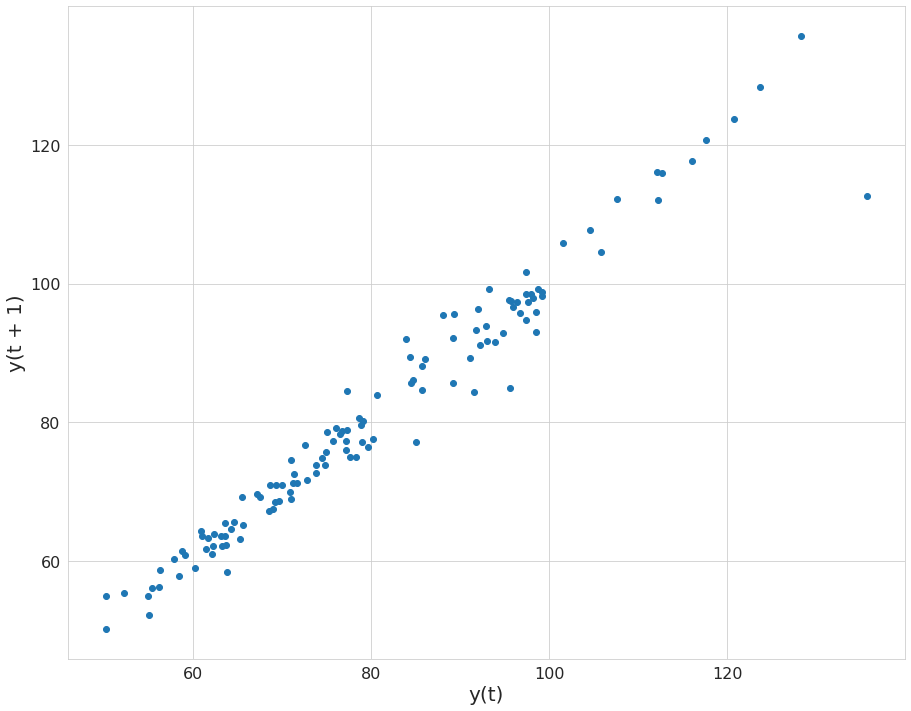

In [22]:
lag_plot(y['Open']);

Here there is a **positive correlation** relationship.

**<font size="2"><a href="#summary">Back to summary</a></font>**

---

<div id="chap9"><h1 style="color:white;background:#5963ab;border-radius:5px;padding:30px;font-family:'Arial', cursive;font-size:50px;text-align:center">Moving Average (MA)</h1></div>

<font color='#5963ab' size='4'>The maths behind MA</font>

<br>Moving average is the estimation of the trend-cycle at time t, and is obtained by averaging the values of the time series within k periods of t. Observations that are nearby in time are also likely to be close in value. Therefore, the average eliminates some of the randomness in the data, leaving a smooth trend-cycle component.

It can be written as

$$ \hat{T_t} = \frac{1}{m}\sum_{j=-k}^{k}y_{t+j}$$

where $m = 2k + 1$. That is, the estimate of the trend-cycle at time $t$ is obtained by averaging values of the time series within k periods of $t$.

* Smaller windows will lead to more noise.
* It will always lag by the size of the window.
* It will never reach the full peak or valley of the data due to the averaging.
* It does not really inform you about possible future behavior, all it really does is describe trends in your data.
* Extreme historical values can skew MA significantly.

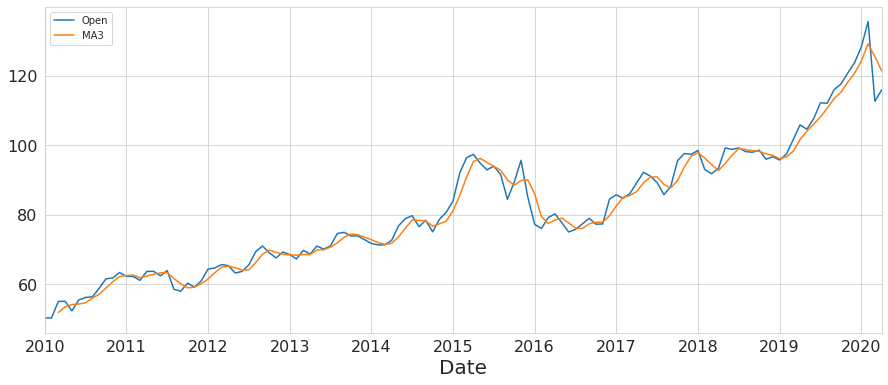

In [23]:
# Aggregating the Time Series to a monthly scaled index
y = imputed_air_liquide[['Date','Open']].copy()
y.set_index('Date', inplace=True)
y.index = pd.to_datetime(y.index)
y = y.resample('1M').mean()

# Compute rolling mean with window size of 3
y['MA3'] = y.rolling(window=3).mean() 

# Plot the resulting time series
y.plot(figsize=(15,6))

**<font size="2"><a href="#summary">Back to summary</a></font>**

---

<div id="chap10"><h1 style="color:white;background:#5963ab;border-radius:5px;padding:30px;font-family:'Arial', cursive;font-size:50px;text-align:center">Exponential Smoothing</h1></div>

Exponential smoothing assigns **exponentially decreasing weights** for **newest** to **oldest** observations. In other words, the older the data, the less priority (“weight”) the data is given. Newer data is seen as more relevant and is assigned more weight. Smoothing parameters usually denoted by $\alpha$ ( $0<\alpha\leq1$) determine the weights for observations. Exponential smoothing is usually used to make **short term forecasts**, as longer term forecasts using this technique **can be quite unreliable**.

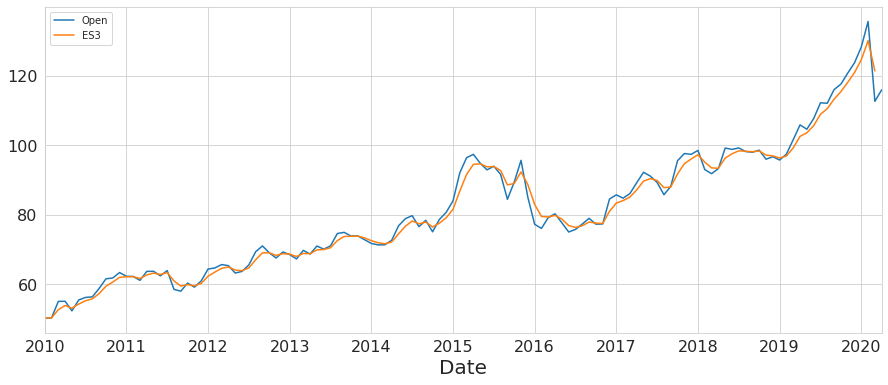

In [24]:
# Setting parameters value
span = 3
# Weights of observations
alpha = 2/(span+1)

# Plot Simple exponential smoothing
# Fit the model using SimpleExpSmoothing and set smoothing level alpha to alpha
# Shift the fitted values by one time step to plot them against the original data
y['ES3'] = SimpleExpSmoothing(y['Open']).fit(smoothing_level = alpha, optimized = False).fittedvalues.shift(-1)

# Plot the original 'Open' values and the Simple exponential smoothing fitted values
y[['Open','ES3']].plot(figsize=(15,6))

<font color='#5963ab' size='4'>Simple, Double, Triple exponential Smoothing ?</font>

<br>**Simple Exponential Smoothing** employs a **weighted moving average with exponentially decreasing weights**.

**Double Exponential Smoothing** adds a second smoothing factor $\beta$ ($0<\beta\leq1$) that addresses trends in the data. The benefit here is that the model can anticipate future increases or decreases where the level model would only work from recent calculations. We can also address different types of change (growth/decay) in the trend. If a time series displays a straight-line sloped trend, you would use an additive adjustment. If the time series displays an exponential (curved) trend, you would use a multiplicative adjustment.

**Triple Exponential Smoothing** (also called the Multiplicative Holt-Winters), the method is usually more reliable for parabolic trends or data that shows trends and seasonality.

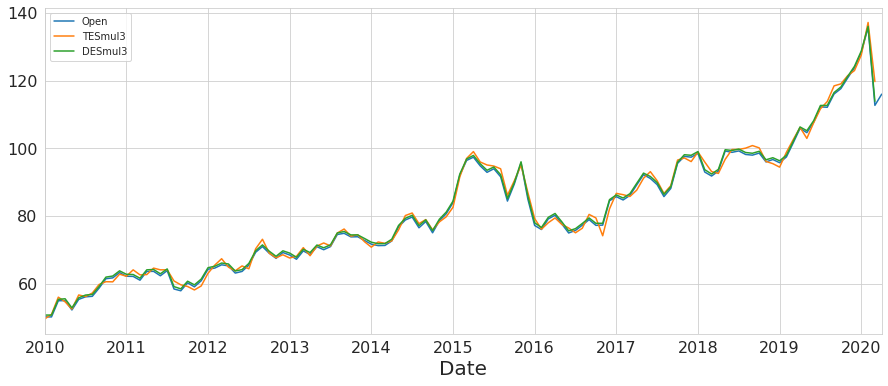

In [25]:
# Plot Double and Triple exponential smoothing

# Double Exponential Smoothing (Holt's Linear Method)
y['DESmul3'] = ExponentialSmoothing(y['Open'], trend='add').fit().fittedvalues.shift(-1)

# Triple Exponential Smoothing (Holt-Winters' Method)
y['TESmul3'] = ExponentialSmoothing(y['Open'], trend='add', seasonal='add', seasonal_periods=12).fit().fittedvalues.shift(-1)

# Plot the original time series and the two smoothed versions
y[['Open', 'TESmul3', 'DESmul3']].plot(figsize=(15, 6))

**<font size="2"><a href="#summary">Back to summary</a></font>**

----

<div id="chap11"><h1 style="color:white;background:#5963ab;border-radius:5px;padding:30px;font-family:'Arial', cursive;font-size:50px;text-align:center">Forecasting with Auto ARIMA</h1></div>

Now we are going to create an ARIMA model and will train it with the closing price of the stock on the train data. So let us split the data into training and test set and visualize it.

In [26]:
# Reverse index so the dataframe is from oldest to newest values
imputed_air_liquide = imputed_air_liquide.reindex(index=imputed_air_liquide.index[::-1])

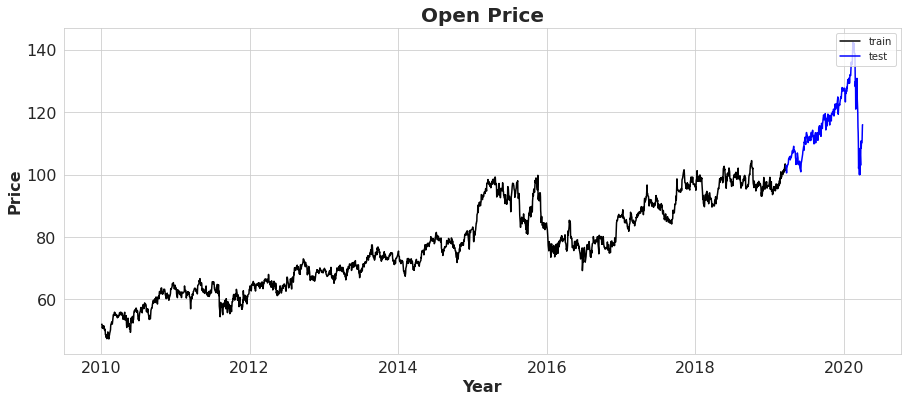

In [27]:
# Split data into train and validation set 90/10
air_liquide_train, air_liquide_val = imputed_air_liquide[:int(len(imputed_air_liquide)*0.9)], imputed_air_liquide[int(len(imputed_air_liquide)*0.9):]

# Set the index to the 'Date' column for both train and validation sets
air_liquide_val = air_liquide_val.set_index('Date', drop=False)
air_liquide_train = air_liquide_train.set_index('Date', drop=False)

# Plot the train and validation sets as separate lines
fig, ax = plt.subplots(figsize=(15, 6))
sns.lineplot(air_liquide_train['Date'], air_liquide_train['Open'], color = 'black')
sns.lineplot(air_liquide_val['Date'], air_liquide_val['Open'], color = 'blue')

# Formatting
ax.set_title('Open Price', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Year', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('Price', fontsize = 16, fontdict=dict(weight='bold'))
plt.tick_params(axis='y', which='major', labelsize=16)
plt.tick_params(axis='x', which='major', labelsize=16)
plt.legend(loc='upper right' ,labels = ('train', 'test'))

It's time to select the parameters p, q, and d for the ARIMA model. Previously, we determined the values of p, d, and q by examining the ACF and PACF plots, but now we will use Auto ARIMA to find the best parameters without even plotting ACF and PACF graphs.

**Auto ARIMA**: Automatically identifies the optimal order for an ARIMA model.
The auto_arima function aims to find the most suitable parameters for an ARIMA model and returns a fitted ARIMA model. This function is based on the widely used R function, forecast::auto.arima.
The auto_arima function operates by performing differencing tests (i.e., Kwiatkowski-Phillips-Schmidt-Shin, Augmented Dickey-Fuller, or Phillips-Perron) to determine the order of differencing, d, and then fits models within the specified ranges of start_p, max_p, start_q, and max_q. If the seasonal option is enabled, auto_arima also seeks to identify the optimal P and Q hyperparameters after performing the Canova-Hansen test to determine the optimal order of seasonal differencing, D.

In [28]:
%%time
model_autoARIMA = auto_arima(air_liquide_train['Open'])

""", 
                             start_p = 0, 
                             start_q = 0,
                             test = 'adf', # use adftest to find optimal 'd'
                             max_p = 3,
                             max_q = 3, # maximum p and q
                             m = 7, # frequency of series
                             seasonal = False,
                             start_P = 0, 
                             D = 0, 
                             trace = True,
                             error_action = 'ignore',  
                             stepwise = True
"""

print(model_autoARIMA.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2340
Model:               SARIMAX(1, 1, 2)   Log Likelihood               -3407.252
Date:                Thu, 20 Apr 2023   AIC                           6822.504
Time:                        17:44:56   BIC                           6845.534
Sample:                             0   HQIC                          6830.894
                               - 2340                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9603      0.023     42.607      0.000       0.916       1.004
ma.L1         -1.0936      0.028    -38.388      0.000      -1.149      -1.038
ma.L2          0.1154      0.018      6.403      0.0

In the comment, you can see the parameters used based on the documentation and the Time Series at hand. However, I wasn't entirely satisfied with the prediction (The best model was an ARMA(1,1), which was decreasing, whereas the trend has been increasing for the past 10 years).
To be honest, I encountered some difficulties in fine-tuning this model. I believe <a href='https://alkaline-ml.com/pmdarima/tips_and_tricks.html'>this</a> resource could be helpful. If you have any suggestions on the proper way to approach this, please feel free to leave a comment. I would greatly appreciate it.

Next, create an ARIMA model with provided optimal parameters p, d and q.

In [29]:
model = ARIMA(air_liquide_train['Open'], order = (1, 1, 2))
# disp=-1: no output

fitted = model.fit(disp = -1)
print(fitted.summary())

                             ARIMA Model Results                              
Dep. Variable:                 D.Open   No. Observations:                 2339
Model:                 ARIMA(1, 1, 2)   Log Likelihood               -3403.083
Method:                       css-mle   S.D. of innovations              1.036
Date:                Thu, 20 Apr 2023   AIC                           6816.166
Time:                        17:44:57   BIC                           6844.954
Sample:                             1   HQIC                          6826.653
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0195      0.002     10.373      0.000       0.016       0.023
ar.L1.D.Open     0.9865      0.004    276.704      0.000       0.980       0.994
ma.L1.D.Open    -1.1254      0.021    -52.37

Now let's start forecast the stock prices on the test dataset with 95% confidence level.

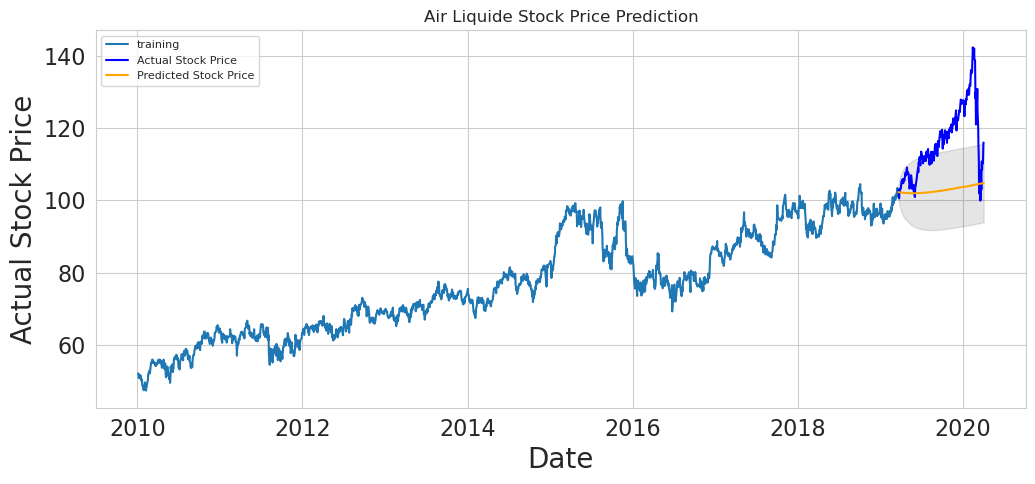

In [30]:
# Forecast 260 next observations 
fc, se, conf = fitted.forecast(260, alpha=0.05)  # 95% confidence
fc_series = pd.Series(fc, index=air_liquide_val.index)
lower_series = pd.Series(conf[:, 0], index=air_liquide_val.index)
upper_series = pd.Series(conf[:, 1], index=air_liquide_val.index)

# Plotting the predicted and actual stock prices
plt.figure(figsize=(12,5), dpi=100)
plt.plot(air_liquide_train['Open'], label='training')
plt.plot(air_liquide_val['Open'], color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('Air Liquide Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Actual Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

As you can observe, our model performed quite well. Additionally, let's evaluate the commonly used accuracy metrics to assess the quality of our forecast results

In [31]:
# Report performances
mse = mean_squared_error(air_liquide_val['Open'], fc)
print('MSE: '+str(mse))
mae = mean_absolute_error(air_liquide_val['Open'], fc)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(air_liquide_val['Open'], fc))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(fc - air_liquide_val['Open'])/np.abs(air_liquide_val['Open']))
print('MAPE: '+str(mape))

MSE: 252.96996460871327
MAE: 13.214238506419186
RMSE: 15.905029538127657
MAPE: 0.10858300768230013


A MAPE (Mean Absolute Percentage Error) of approximately 11% suggests that the model is about 89% accurate in predicting the test set observations. Overall, the value is close. However, the model was unable to predict the higher than normal growth for the past year, nor could it foresee the COVID-19 crisis, which resulted in a decrease in Open prices.

**<font size="2"><a href="#summary">Back to summary</a></font>**

---

# References

* https://www.machinelearningplus.com/time-series/time-series-analysis-python/

* https://www.udemy.com/python-for-time-series-data-analysis/

* https://machinelearningmastery.com/time-series-data-visualization-with-python/

* https://www.statisticshowto.com/exponential-smoothing/

* https://otexts.com/fpp2/components.html

<hr>
<br>
<div align='justify'><font color="#353B47" size="4">I appreciate your time and effort in reading this notebook. My aim is to address your questions and curiosities in a comprehensive and clear manner. I welcome any constructive feedback that will help me improve and motivate me to deliver higher quality content. My primary goal is to share knowledge and learn from others while fueling my passion for the subject. If you found this notebook valuable, please consider upvoting and sharing my work. </font></div>
<br>
<div align='center'><font color="#353B47" size="3">Thank you, and let passion be your guide.</font></div>